In [41]:
# Importing the necessary libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [42]:
# Getting the stock quote
df = pd.read_csv('/content/DRAGARWQ.BO.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,700.450012,715.000000,699.000000,699.450012,692.276489,2142
1,2018-01-02,710.000000,711.950012,700.000000,706.799988,699.551086,738
2,2018-01-03,702.000000,740.000000,700.000000,720.900024,713.506470,2453
3,2018-01-04,755.000000,755.000000,720.000000,730.000000,722.513123,546
4,2018-01-05,740.000000,740.000000,708.200012,721.450012,714.050842,824
...,...,...,...,...,...,...,...
1231,2022-12-26,1299.000000,1299.000000,1179.000000,1211.449951,1211.449951,747
1232,2022-12-27,1244.000000,1244.000000,1176.400024,1216.699951,1216.699951,374
1233,2022-12-28,1200.000000,1224.349976,1183.000000,1204.300049,1204.300049,183
1234,2022-12-29,1180.250000,1229.000000,1180.250000,1213.250000,1213.250000,191


In [43]:
# Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Converting the dataframe to a numpy array
dataset = data.values

Text(0, 0.5, 'Prices ($)')

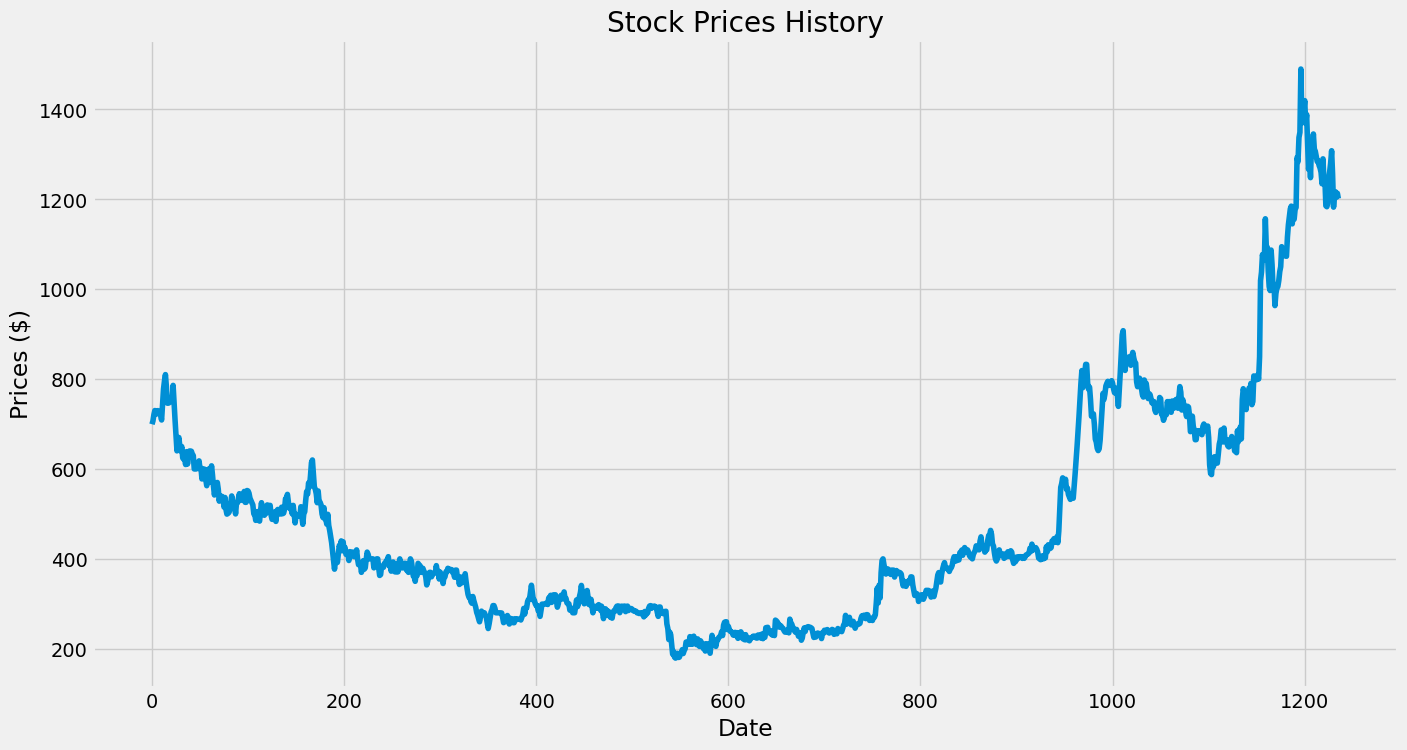

In [44]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [45]:
# Getting the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

In [46]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [47]:
# Creating the training data set
train_data = scaled_data[0:training_data_len, :]

In [48]:
# Splitting the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [49]:
# Converting the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [50]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [51]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [52]:
# Training the model
model.fit(x_train, y_train, batch_size=4, epochs=1)

233/233 [==============================] - 20s 55ms/step - loss: 0.0013


In [53]:
# Creating the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Creating the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Converting the data to a numpy array
x_test = np.array(x_test)

# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [54]:
# Getting the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


8/8 [==============================] - 1s 20ms/step


In [55]:
# Getting the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:', rmse)


RMSE: 1.1746104579326924


In [56]:
# Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()

# Create a new column in the valid DataFrame for the predictions
valid['Predictions'] = predictions

# Use the .loc accessor to set the values for the new column
valid.loc[:, 'Predictions'] = predictions

In [57]:
predictions.shape

(247, 1)

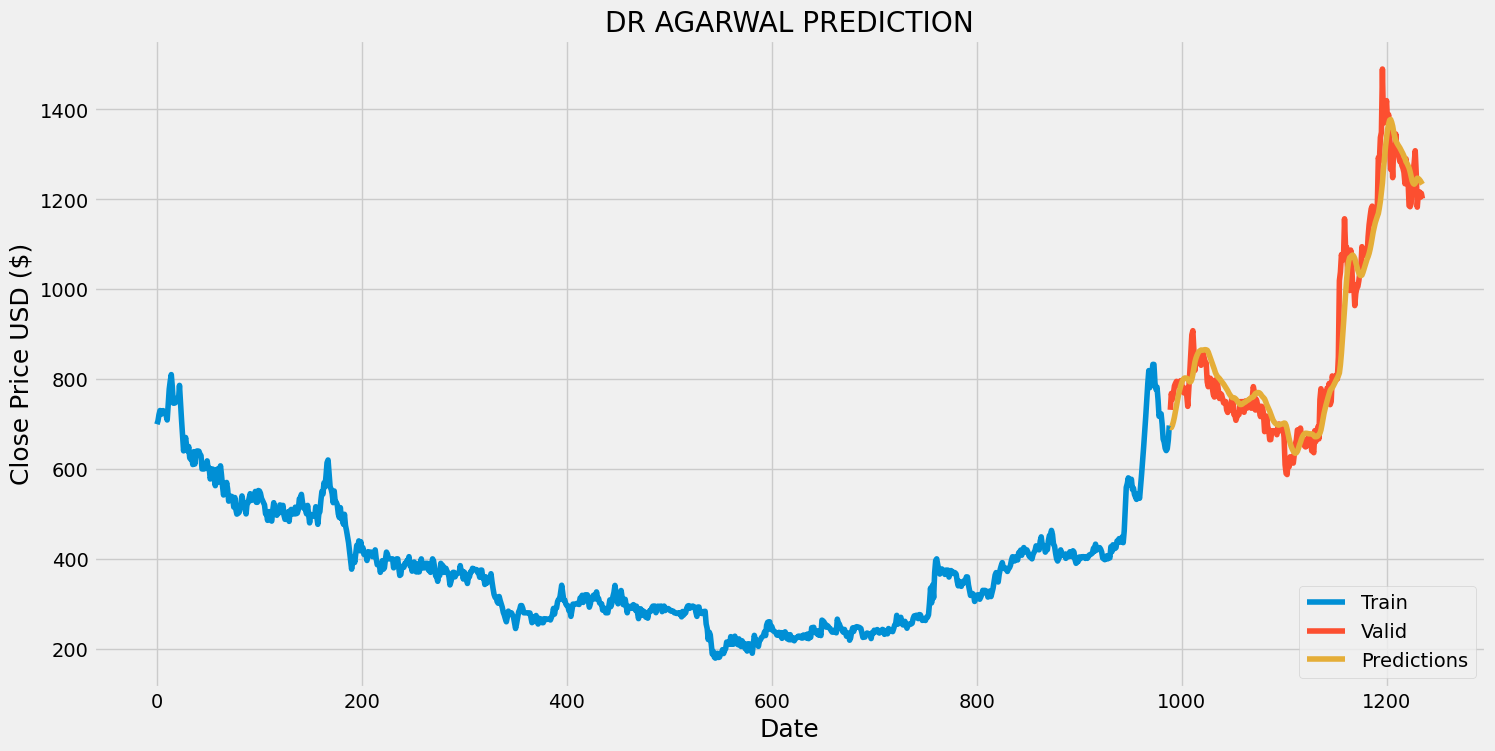

In [58]:
plt.figure(figsize=(16,8))
plt.title('DR AGARWAL PREDICTION')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [59]:
# Predicting the stock prices for the next 365 days
DR_Agarwal_quote = pd.read_csv('/content/DRAGARWQ.BO.csv')
new_df = DR_Agarwal_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted price for the next day:', pred_price)


1/1 [==============================] - 0s 29ms/step
Predicted price for the next day: [[1229.2748]]


In [60]:
forecast = []
forecast.append(pred_price)

for i in range(1, 365):
    last_60_days_scaled = scaler.transform(last_60_days[-60:].reshape(-1, 1))
    last_60_days = np.append(last_60_days[1:], pred_price)
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    forecast.append(pred_price)

1/1 [==============================] - 0s 28ms/step


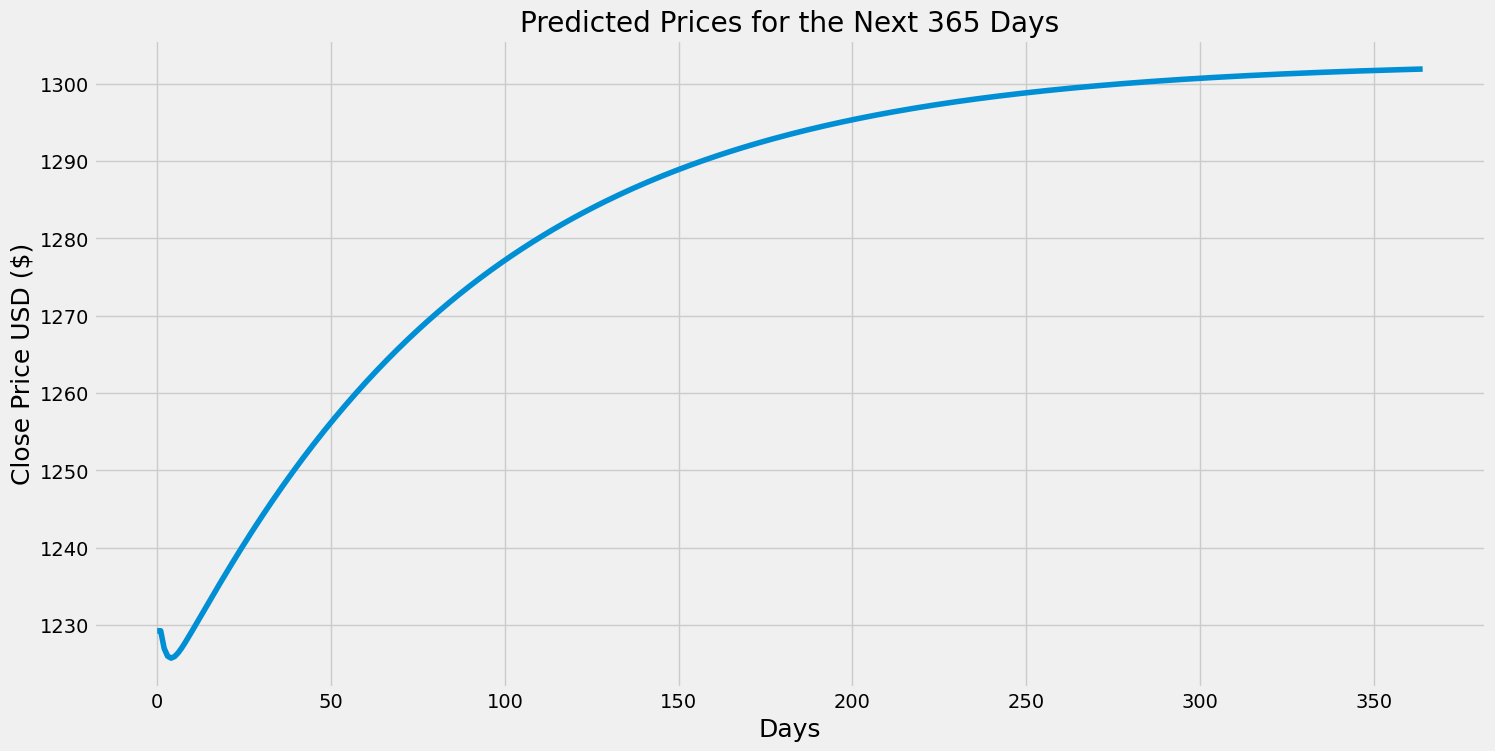

In [61]:
forecast = np.array(forecast).flatten()
plt.figure(figsize=(16,8))
plt.title('Predicted Prices for the Next 365 Days')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(forecast)
plt.show()

In [62]:
forecast

array([1229.2748, 1229.2748, 1227.007 , 1225.995 , 1225.7388, 1225.939 ,
       1226.4052, 1227.021 , 1227.7177, 1228.4567, 1229.2167, 1229.9861,
       1230.7589, 1231.5323, 1232.3038, 1233.073 , 1233.8389, 1234.6005,
       1235.3575, 1236.1099, 1236.8567, 1237.5979, 1238.3326, 1239.0616,
       1239.7842, 1240.4996, 1241.2087, 1241.911 , 1242.6063, 1243.295 ,
       1243.9764, 1244.6512, 1245.319 , 1245.9797, 1246.6338, 1247.2808,
       1247.9211, 1248.5547, 1249.1814, 1249.8016, 1250.4152, 1251.0221,
       1251.6228, 1252.2168, 1252.8043, 1253.3856, 1253.9608, 1254.5295,
       1255.0924, 1255.6489, 1256.1995, 1256.7439, 1257.2823, 1257.8151,
       1258.3418, 1258.8627, 1259.3783, 1259.888 , 1260.392 , 1260.8906,
       1261.3835, 1261.8708, 1262.3531, 1262.8298, 1263.3013, 1263.7676,
       1264.2288, 1264.6844, 1265.1353, 1265.5809, 1266.0219, 1266.4578,
       1266.8887, 1267.3147, 1267.7357, 1268.1525, 1268.5642, 1268.9714,
       1269.3743, 1269.7721, 1270.1655, 1270.5546, 